In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# Dataset Reorganizing

Here we would like to first work on a subset of the dataset

In [ ]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM2/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM2/'


In [ ]:
df = pd.read_csv(path+'HAM10000_metadata.csv')
df.shape
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
listdir = os.listdir

# Get the contents of the subset
contents = listdir(path+'HAM10000_images_part_1/')

# Filter the results to only include image files
image_files = [file for file in contents if file.endswith('.jpg')]

# Convert the results to a list
image_file_names = list(image_files)
len(image_file_names)

1661

In [ ]:
image_file_names[1] # To check on the image file name construction

'ISIC_0024954.jpg'

The file name of images is encoded as **image_id.jpg**.

In [ ]:
# Use list comprehension to remove the extension from each image name
image_ids = [name.split('.')[0] for name in image_file_names]
image_ids[1]
len(image_ids)
subset = df[df['image_id'].isin(image_ids)]
subset.to_csv(path+'new_metadata.csv')
df1 = pd.read_csv(path+'new_metadata.csv')
df1.shape

(1661, 8)

In [ ]:
image_paths = []

for image_id in df1['image_id']:
    image_path = os.path.join(path+'HAM10000_images_part_1', image_id + '.jpg')
    image_paths.append(image_path)

In [ ]:
# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# # Load the metadata.csv file
# labels = df1['dx']

In [ ]:
df1['image_path'] = image_paths
df1 = df1.drop('Unnamed: 0', axis=1)
df1.shape

(1661, 8)

In [ ]:
df1.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
2,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
3,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
4,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
5,HAM_0001949,ISIC_0025767,bkl,histo,70.0,male,trunk,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
6,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
7,HAM_0003301,ISIC_0025033,bkl,histo,60.0,male,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
8,HAM_0004884,ISIC_0025937,bkl,histo,75.0,male,upper extremity,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
9,HAM_0006574,ISIC_0025567,bkl,histo,40.0,male,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...


In [ ]:
image_ids = df1['image_id']
image_paths = df1['image_path']

In [ ]:
# df1.to_csv(path+'clean_metadata.csv')

(600, 450)


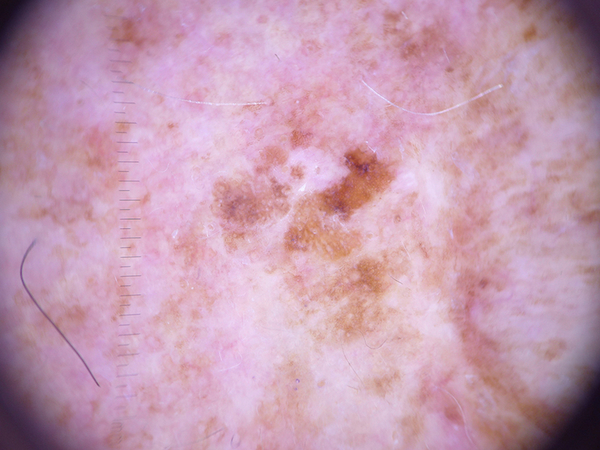

In [ ]:
# loading a sample image
sample_image = Image.open(image_paths[0])
print(sample_image.size)
sample_image


#Model Training

In [ ]:
metadata = pd.read_csv(path+'clean_metadata.csv')

(1661, 128, 128, 3)
(1661,)


(1328, 128, 128, 3)

(333, 128, 128, 3)

(1328, 7)

(333, 7)

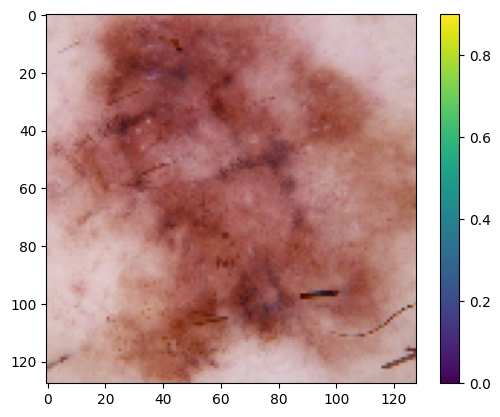

In [ ]:
def load_and_crop(image, crop_size, normalized=True):
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    # image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    image = image.crop((left, top, right, bottom))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# Load and preprocess the images
images = []
labels = []

for i, row in metadata.iterrows():
    image = load_img(row['image_path'], target_size=(150, 200))
    image = load_and_crop(image, 128)
    images.append(image)
    labels.append(row['dx'])

# Convert the images and labels to numpy arrays and adding a fake color channel
X = np.array(images).reshape(-1, 128, 128, 3)
print(X.shape)
y = np.array(labels)
print(y.shape)

# Convert the labels to integer values
y = pd.Series(labels).factorize()[0]

# Convert the labels to one-hot encoded vectors
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

plt.imshow(X_train[0])

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/35
67/67 [==============================] - 58s 118ms/step - loss: 6.3198 - accuracy: 0.5723 - val_loss: 7.4793 - val_accuracy: 0.6517
Epoch 2/35
67/67 [==============================] - 4s 55ms/step - loss: 5.6494 - accuracy: 0.6928 - val_loss: 6.1302 - val_accuracy: 0.6547
Epoch 3/35
67/67 [==============================] - 5s 68ms/step - loss: 5.2388 - accuracy: 0.7176 - val_loss: 5.2849 - val_accuracy: 0.6817
Epoch 4/35
67/67 [==============================] - 4s 55ms/step - loss: 4.8370 - accuracy: 0.7357 - val_loss: 4.9158 - val_accuracy: 0.6997
Epoch 5/35
67/67 [==============================] - 4s 54ms/step - loss: 4.4561 - accuracy: 0.7523 - val_loss: 4.5666 - val_accuracy: 0.6997
Epoch 6/35
67/67 [==============================] - 5s 68ms/step - loss: 4.1082 - accuracy: 0.7824 - val_loss: 4.2892 - val_accuracy: 0.7147
Epoch 7/35
67/67 [==============================] - 4s 56ms/step - loss: 3.7459 - accur

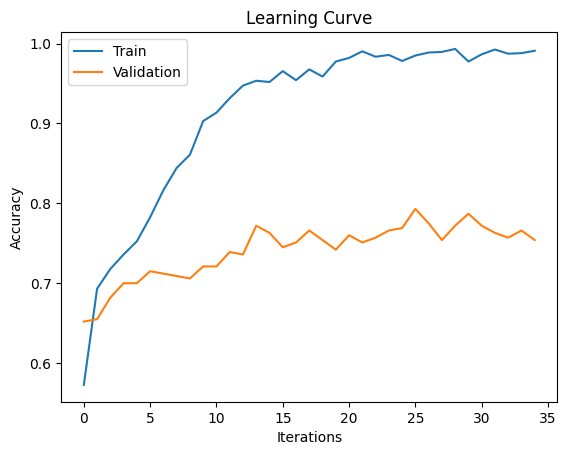

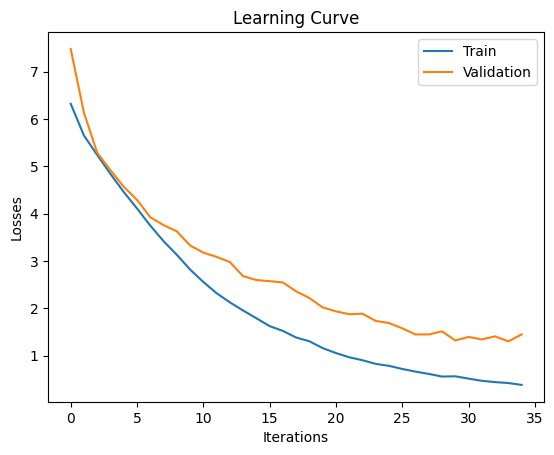

In [ ]:
image_size = (128, 128, 3)

# Load the VGG16 model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16.trainable = False

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',pooling='avg', input_shape=(128,128, 3))

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # FFT layer
    # FourierFilter(),
    

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test))

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [ ]:
# Creat Fourier Mask
def create_mask(h, w, R_factor, r_factor): 
    center = (h//2, w//2) # use the middle of the image
    s = min(h, w)
    if R_factor <= 2:
        R_factor = 2
    R = round(s/R_factor)
    if R_factor >= r_factor:
        r = 0
    else:
        r = round(s/r_factor)

    X,Y = tf.meshgrid(tf.range(h), tf.range(w))

    dist_from_center = tf.sqrt(tf.cast((X - center[0])**2 + (Y-center[1])**2, dtype=tf.float32))

    mask = np.logical_and(dist_from_center >= r, dist_from_center < R)

    return mask

In [ ]:
class FourierFilter(tf.keras.layers.Layer):
    def __init__(self):
        super(FourierFilter, self).__init__()
        
    def build(self, input_shape):
        # Setting up shape parameters
        _, self.h, self.w, self.c = input_shape
        self.R_factor = 10 #@param {type:"slider", min:0, max:100, step:5}
        self.r_factor = 250 #@param {type:"slider", min:0, max:1000, step:10}
        
        # Defining the mask in the layer
        mask = create_mask(self.h, self.w, self.R_factor, self.r_factor)
        mask = tf.cast(mask, dtype=tf.complex64)
        self.mask = mask
        
    def get_mask(self):
        return self.mask
            
    def call(self, inputs):
        # Apply 2D Fourier transform to each channel
        inputs = tf.cast(inputs, dtype=tf.complex64)
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        inputs_fft = tf.signal.fft2d(inputs)
        inputs_fft = tf.signal.fftshift(inputs_fft)
                
        # Apply circular mask
        inputs_fft *= self.mask
        
        # Apply 2D inverse Fourier transform
        inputs_filtered = tf.signal.ifftshift(inputs_fft)
        inputs_filtered = tf.signal.ifft2d(inputs_filtered)
        inputs_filtered = tf.abs(inputs_filtered)
        inputs_filtered = tf.transpose(inputs_filtered, perm=[0,2,3,1])
        
        return inputs_filtered

In [ ]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # FFT layer
    FourierFilter(),
    

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fourier_filter_5 (FourierFi  (None, 128, 128, 3)      0         
 lter)                                                           
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                 903       
                                                      

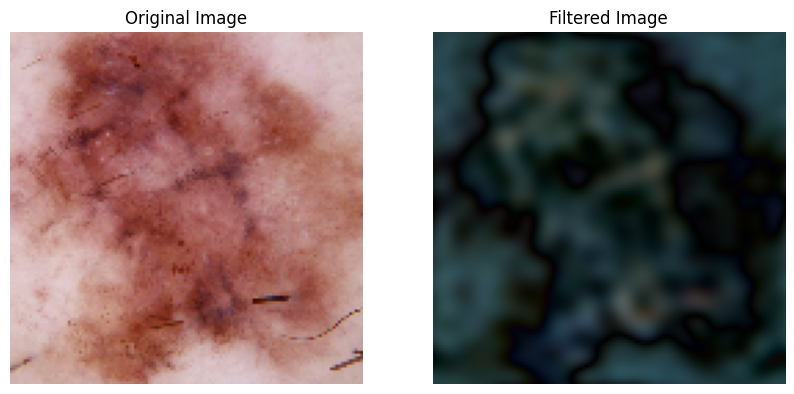

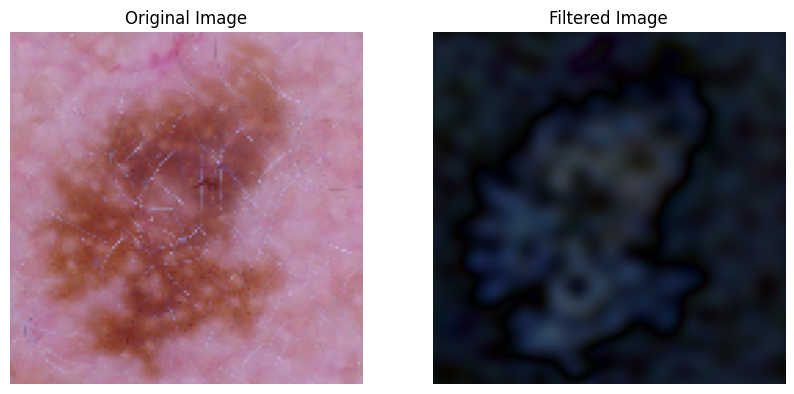

In [ ]:
# Check the FourierFilter output

ft_output = model.layers[0](X_train[0:2])

for i in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    img = X_train[i]
    filtered_img = ft_output[i]
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    axs[1].imshow(filtered_img)
    axs[1].axis('off')
    axs[1].set_title('Filtered Image')
plt.show()


Epoch 1/35
67/67 [==============================] - 43s 79ms/step - loss: 5.5866 - accuracy: 0.8057 - val_loss: 6.0230 - val_accuracy: 0.7177
Epoch 2/35
67/67 [==============================] - 5s 67ms/step - loss: 4.8041 - accuracy: 0.9578 - val_loss: 5.7969 - val_accuracy: 0.7297
Epoch 3/35
67/67 [==============================] - 4s 55ms/step - loss: 4.3764 - accuracy: 0.9789 - val_loss: 5.5870 - val_accuracy: 0.7147
Epoch 4/35
67/67 [==============================] - 4s 55ms/step - loss: 3.9762 - accuracy: 0.9804 - val_loss: 5.1352 - val_accuracy: 0.7177
Epoch 5/35
67/67 [==============================] - 5s 69ms/step - loss: 3.5870 - accuracy: 0.9812 - val_loss: 4.6873 - val_accuracy: 0.7207
Epoch 6/35
67/67 [==============================] - 4s 54ms/step - loss: 3.2386 - accuracy: 0.9857 - val_loss: 4.4379 - val_accuracy: 0.7297
Epoch 7/35
67/67 [==============================] - 4s 56ms/step - loss: 2.8984 - accuracy: 0.9895 - val_loss: 4.3774 - val_accuracy: 0.6907
Epoch 8/35
6

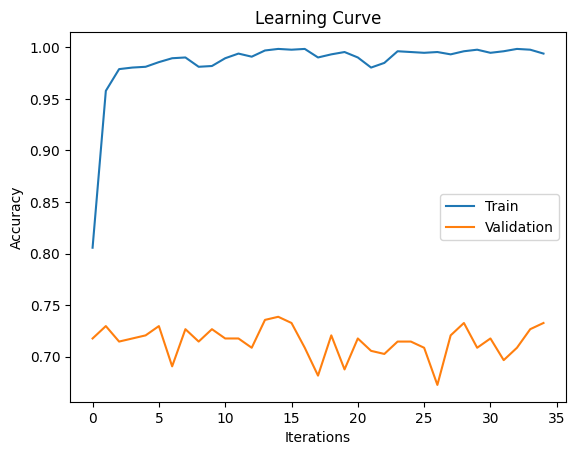

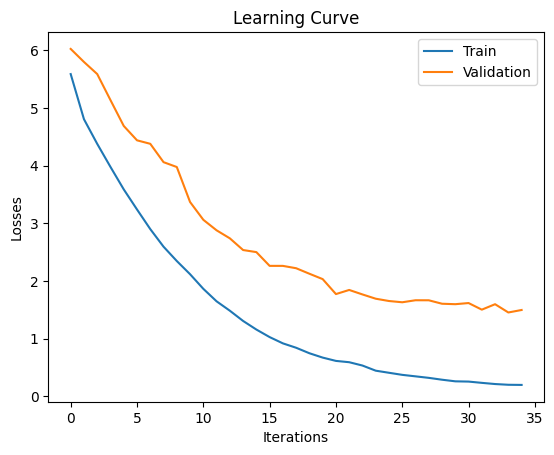

In [ ]:
# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test))

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()